# (04) single g: curvature

**Motivation**: Fix all other g, change only 1 of them. How does the curvature of z look like? If flat, then disentangled.

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
def compute_mu_sd(x, axis: int = 0):
    mu = x.mean(axis, keepdims=True)
    sd = x.std(axis, keepdims=True)
    return mu, sd


from analysis.linear import mi_analysis

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

## Load

In [3]:
# skip + x
# model_name = 'fixate1_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)'
# fit_name = 'ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_04_24,18:00)'

# skip + 0.1 * x
model_name = 'fixate1_k-32_z-14x[5,10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)'
fit_name = 'skip+0.1x_ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_05_30,09:01)'

tr, meta = load_model(
    model_name=model_name,
    fit_name=fit_name,
    verbose=False,
    device='cuda',
    shuffle=False,
)

### Lin Reg

In [4]:
%%time

g, select_lbl = prep_rofl(
    labels=list(LBL2TEX) + [
        'slf_v_norm',
        'slf_v_theta',
        'slf_v_phi']
)
z = {
    k: tr.forward(k, True)[0]['z']
    for k in g
}

CPU times: user 6min 42s, sys: 2min 2s, total: 8min 44s
Wall time: 8min 44s


In [5]:
mu_sd = {
    'g': compute_mu_sd(np.concatenate(
        [v for v in g.values()])),
    'z': compute_mu_sd(np.concatenate(
        [v for v in z.values()])),
}

In [6]:
idx = 6
idx, select_lbl[idx]

(6, 'obj0_alpha_y')

In [7]:
lr = sk_linear.LinearRegression().fit(
    shift_rescale(z['trn'], *mu_sd['z']),
    shift_rescale(g['trn'], *mu_sd['g'])[:, idx],
)
pred = lr.predict(shift_rescale(np.concatenate(
    [z['vld'], z['tst']]), *mu_sd['z']))
true = shift_rescale(np.concatenate(
    [g['vld'], g['tst']]), *mu_sd['g'])[:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.925726033402866

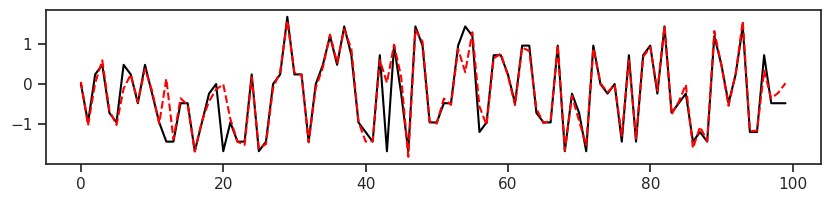

In [12]:
fig, ax = create_figure(1, 1, (10, 2))
ax.plot(true[:100], 'k')
ax.plot(pred[:100], 'r--')
plt.show()

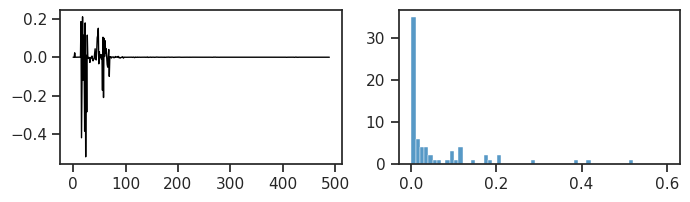

In [13]:
u_hat = lr.coef_ / sp_lin.norm(lr.coef_)

fig, axes = create_figure(1, 2, (8, 2))
axes[0].plot(u_hat, lw=1, color='k')
sns.histplot(np.abs(u_hat), bins=np.linspace(0.001, 0.6 + 0.001, 61), ax=axes[1])
axes[1].set_ylabel('')
plt.show()

## ROFL test